In [ ]:
!pip install mne
!pip install mne-icalabel
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Constants
FS = 128  # Sampling frequency
METADATA_COLUMNS =  [
    'EEG.Counter', 'EEG.Interpolated', 'EEG.RawCq', 'EEG.Battery',
    'EEG.BatteryPercent', 'EEG.MarkerHardware'
]

print("Libraries imported and constants initialized.")

Libraries imported and constants initialized.


In [ ]:
import os
import re
import pandas as pd

# Function to load and preprocess each participant's EEG CSV individually
def load_dataset_file_by_file(root_folder):
    dataset = []  # List of tuples: (dataframe, label, participant_id)

    for letter_folder in sorted(os.listdir(root_folder)):  # Optional: sort for consistency
        letter_path = os.path.join(root_folder, letter_folder)
        if not os.path.isdir(letter_path):
            print(f"Skipping {letter_path} (not a directory)")
            continue

        print(f"Processing letter folder: {letter_folder}")
        label = letter_folder  # Use folder name as label

        for file in os.listdir(letter_path):
            file_path = os.path.join(letter_path, file)
            if not os.path.isfile(file_path) or not file.endswith('.csv'):
                print(f"  Skipping {file} (not a .csv file)")
                continue

            print(f"  Reading participant file: {file}")
            try:
                df = pd.read_csv(file_path, skiprows=1)

                # Extract participant name using regex
                match = re.match(r'(par\.\d+)', file)
                participant_name = match.group(0) if match else "unknown"

                # Append as a tuple: (dataframe, label, participant_id)
                dataset.append((df, label, participant_name))
            except Exception as e:
                print(f"  Error reading {file_path}: {e}")
                continue

    return dataset

# Example usage
ROOT_FOLDER = "/content/drive/MyDrive/كلمات"
dataset = load_dataset_file_by_file(ROOT_FOLDER)

# Check an example
print(f"\nTotal samples loaded: {len(dataset)}")
print("Example entry:")
df_sample, label_sample, participant_sample = dataset[0]
print(f"Participant: {participant_sample}, Label: {label_sample}")
print(df_sample.head())


Processing letter folder: اختر
  Reading participant file: par.3 اختر_EPOCX_206412_2023.12.24T10.58.33+03.00.md.csv
  Reading participant file: par.20  اختر_EPOCX_206412_2023.12.24T12.49.20+03.00.md.csv
  Reading participant file: par.17 اختر_EPOCX_206412_2023.12.24T13.25.58+03.00.md.csv
  Reading participant file: par.6 اختر_EPOCX_206412_2023.12.21T13.06.47+03.00.md.csv
  Reading participant file: par.11 اختر_EPOCX_206412_2023.12.25T11.16.35+03.00.md.csv
  Reading participant file: par.22 اختر_EPOCX_206412_2023.12.24T14.22.05+03.00.md.csv
  Reading participant file: par.2 اختر_EPOCX_206420_2023.12.25T14.01.11+03.00.md.csv
  Reading participant file: par.14 اختر_EPOCX_206412_2023.12.25T10.47.32+03.00.md.csv
  Reading participant file: par.8 اختر_EPOCX_206412_2023.12.24T11.27.08+03.00.md.csv
  Reading participant file: par.15 اختر_EPOCX_206412_2023.12.24T11.49.28+03.00.md.csv
  Reading participant file: par.7 اختر_EPOCX_206412_2023.12.24T12.18.26+03.00.md.csv
  Reading participant file:

In [ ]:
# Metadata columns to exclude from EEG signal channels
METADATA_COLUMNS = ['Time', 'Event Id', 'Event Date', 'Event Duration', 'Event Description']

# Function to validate EEG data for a single DataFrame
def validate_eeg_data(df):
    # Keep only EEG channels (not metadata)
    valid_columns = [col for col in df.columns if col.startswith('EEG.') and col not in METADATA_COLUMNS]

    if not valid_columns:
        print("  ❌ No valid EEG signal columns identified. Skipping this DataFrame.")
        return None, None

    print(f"  ✅ Validating data with shape: {df.shape}")
    return df[valid_columns].copy(), valid_columns

# Function to validate all entries in the dataset
def validate_all_eeg_data(dataset):
    validated_dataset = []           # Will store (cleaned_df, label, participant)
    valid_columns_map = {}           # Optional: track valid columns per participant
    skipped = 0

    for idx, (df, label, participant) in enumerate(dataset):
        print(f"\n🔍 Processing sample {idx + 1}/{len(dataset)} - Participant: {participant}, Label: {label}")
        validated_df, valid_columns = validate_eeg_data(df)

        if validated_df is not None:
            validated_dataset.append((validated_df, label, participant))
            valid_columns_map[participant] = valid_columns
        else:
            print(f"  ⚠️ Skipping sample from {participant}")
            skipped += 1

    print(f"\n✅ EEG validation complete. Valid samples: {len(validated_dataset)}, Skipped: {skipped}")
    return validated_dataset, valid_columns_map

# Run validation
validated_dataset, valid_columns_map = validate_all_eeg_data(dataset)

# Optional: Preview
df_example, label_example, participant_example = validated_dataset[0]
print(f"\n👤 Participant: {participant_example}, 🏷️ Label: {label_example}, 📐 EEG shape: {df_example.shape}")



🔍 Processing sample 1/359 - Participant: par.3, Label: اختر
  ✅ Validating data with shape: (1386, 68)

🔍 Processing sample 2/359 - Participant: par.20, Label: اختر
  ✅ Validating data with shape: (1413, 68)

🔍 Processing sample 3/359 - Participant: par.17, Label: اختر
  ✅ Validating data with shape: (1388, 68)

🔍 Processing sample 4/359 - Participant: par.6, Label: اختر
  ✅ Validating data with shape: (1394, 68)

🔍 Processing sample 5/359 - Participant: par.11, Label: اختر
  ✅ Validating data with shape: (1369, 68)

🔍 Processing sample 6/359 - Participant: par.22, Label: اختر
  ✅ Validating data with shape: (1379, 68)

🔍 Processing sample 7/359 - Participant: par.2, Label: اختر
  ✅ Validating data with shape: (1380, 68)

🔍 Processing sample 8/359 - Participant: par.14, Label: اختر
  ✅ Validating data with shape: (1384, 68)

🔍 Processing sample 9/359 - Participant: par.8, Label: اختر
  ✅ Validating data with shape: (1376, 68)

🔍 Processing sample 10/359 - Participant: par.15, Label: ا

In [ ]:
CHANNELS_TO_REMOVE = ['EEG.T8', 'EEG.O1', 'EEG.F3']
DESIRED_EEG_CHANNELS = [
    'EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', 'EEG.P7',
    'EEG.O1', 'EEG.O2', 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4', 'EEG.F8', 'EEG.AF4'
]

def clean_validated_dataset(validated_dataset):
    cleaned_dataset = []

    for idx, (df, label, participant) in enumerate(validated_dataset):
        print(f"\n🧹 Cleaning sample {idx + 1}/{len(validated_dataset)} - Participant: {participant}, Label: {label}")

        # Select only desired channels first
        available_channels = [ch for ch in DESIRED_EEG_CHANNELS if ch in df.columns]
        df_cleaned = df[available_channels].copy()

        # Drop the undesired ones explicitly
        removed_channels = [ch for ch in CHANNELS_TO_REMOVE if ch in df_cleaned.columns]
        df_cleaned.drop(columns=removed_channels, inplace=True)

        print(f"  Removed channels: {removed_channels}")
        print(f"  Shape after cleaning: {df_cleaned.shape}")

        cleaned_dataset.append((df_cleaned, label, participant))

    print(f"\n✅ Finished cleaning all EEG samples. Total cleaned samples: {len(cleaned_dataset)}")
    return cleaned_dataset

# Run the cleaning step
cleaned_dataset = clean_validated_dataset(validated_dataset)

# Example check
df_clean, label_clean, participant_clean = cleaned_dataset[0]
print(f"\n👤 Participant: {participant_clean}, 🏷️ Label: {label_clean}, 📐 Cleaned EEG shape: {df_clean.shape}")



🧹 Cleaning sample 1/359 - Participant: par.3, Label: اختر
  Removed channels: ['EEG.T8', 'EEG.O1', 'EEG.F3']
  Shape after cleaning: (1386, 11)

🧹 Cleaning sample 2/359 - Participant: par.20, Label: اختر
  Removed channels: ['EEG.T8', 'EEG.O1', 'EEG.F3']
  Shape after cleaning: (1413, 11)

🧹 Cleaning sample 3/359 - Participant: par.17, Label: اختر
  Removed channels: ['EEG.T8', 'EEG.O1', 'EEG.F3']
  Shape after cleaning: (1388, 11)

🧹 Cleaning sample 4/359 - Participant: par.6, Label: اختر
  Removed channels: ['EEG.T8', 'EEG.O1', 'EEG.F3']
  Shape after cleaning: (1394, 11)

🧹 Cleaning sample 5/359 - Participant: par.11, Label: اختر
  Removed channels: ['EEG.T8', 'EEG.O1', 'EEG.F3']
  Shape after cleaning: (1369, 11)

🧹 Cleaning sample 6/359 - Participant: par.22, Label: اختر
  Removed channels: ['EEG.T8', 'EEG.O1', 'EEG.F3']
  Shape after cleaning: (1379, 11)

🧹 Cleaning sample 7/359 - Participant: par.2, Label: اختر
  Removed channels: ['EEG.T8', 'EEG.O1', 'EEG.F3']
  Shape after cl

In [ ]:
import mne

FS = 128  # Set your actual sampling frequency here

# Function to create an MNE Raw object
def create_raw_object(eeg_data, sfreq=FS):
    data = eeg_data.to_numpy().T  # Transpose to shape (n_channels, n_times)
    ch_names = eeg_data.columns.tolist()
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=['eeg'] * len(ch_names))
    raw = mne.io.RawArray(data, info, verbose=False)
    return raw

# Function to rename EEG channels for standard montage compatibility
def rename_eeg_channels(raw_object):
    rename_dict = {
        'EEG.AF3': 'AF3', 'EEG.FC6': 'FC6', 'EEG.AF4': 'AF4', 'EEG.F7': 'F7',
        'EEG.FC5': 'FC5', 'EEG.T7': 'T7', 'EEG.O2': 'O2',
        'EEG.P7': 'P7', 'EEG.P8': 'P8',
        'EEG.F4': 'F4', 'EEG.F8': 'F8'
    }


    raw_object.rename_channels(rename_dict)
    return raw_object

# Create Raw objects for each cleaned entry (per participant)
raw_dataset = []  # Will store (raw_object, label, participant)

for idx, (df_clean, label, participant) in enumerate(cleaned_dataset):
    print(f"\n🧠 Creating Raw object {idx + 1}/{len(cleaned_dataset)} - Participant: {participant}, Label: {label}")

    try:
        raw = create_raw_object(df_clean)
        raw = rename_eeg_channels(raw)
        raw_dataset.append((raw, label, participant))
        print("  ✅ Successfully created and renamed Raw object.")
    except Exception as e:
        print(f"  ❌ Failed to create Raw object for {participant}, label {label}: {e}")



🧠 Creating Raw object 1/359 - Participant: par.3, Label: اختر
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 2/359 - Participant: par.20, Label: اختر
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 3/359 - Participant: par.17, Label: اختر
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 4/359 - Participant: par.6, Label: اختر
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 5/359 - Participant: par.11, Label: اختر
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 6/359 - Participant: par.22, Label: اختر
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 7/359 - Participant: par.2, Label: اختر
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 8/359 - Participant: par.14, Label: اختر
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 9/359 - Participant: par.8, Label: اختر
  ✅ Successfully created and renamed

In [ ]:
from mne.preprocessing import ICA
from mne_icalabel import label_components
import numpy as np

# Apply filters and referencing to a Raw object
def apply_filters_and_reference(raw):
    raw.notch_filter(freqs=50.0, verbose=False)
    raw.filter(l_freq=1.0, h_freq=50.0, verbose=False)
    raw.set_eeg_reference('average', projection=True, verbose=False)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, verbose=False)
    print("  ✅ Filters and referencing applied.")
    return raw

# Perform ICA and clean artifacts for a Raw object
def perform_ica(raw, brain_threshold=0.5):
    ica = ICA(method='infomax', fit_params={'extended': True}, n_components=11, max_iter=1000, random_state=42)
    ica.fit(raw, verbose=False)

    ic_labels = label_components(raw, ica, method="iclabel")

    non_brain_components = [
        idx for idx, (label, prob) in enumerate(zip(ic_labels['labels'], ic_labels['y_pred_proba']))
        if label != 'brain' or prob < brain_threshold
    ]

    ica.exclude = non_brain_components
    raw_cleaned = ica.apply(raw.copy(), verbose=False)

    print(f"  ✅ ICA completed. Excluded components: {non_brain_components}")
    return raw_cleaned

# Check and clean NaN/Inf values from Raw data
def clean_nan_inf(raw):
    data = raw.get_data()
    if np.isnan(data).any() or np.isinf(data).any():
        print("  ⚠️ Detected NaN or Inf values.")
        for i in range(data.shape[0]):
            channel_data = data[i, :]
            channel_mean = np.nanmean(channel_data)
            channel_data[np.isnan(channel_data)] = channel_mean
            channel_data[np.isinf(channel_data)] = channel_mean
            data[i, :] = channel_data
        print("  ✅ NaN/Inf values replaced with channel means.")
    else:
        print("  ✅ No NaN or Inf values detected.")
    raw._data = data
    return raw

# Final cleaned raw dataset: list of (raw_object, label, participant)
cleaned_raw_dataset = []

for idx, (raw_object, label, participant) in enumerate(raw_dataset):
    print(f"\n🧪 Processing sample {idx + 1}/{len(raw_dataset)} - Participant: {participant}, Label: {label}")
    try:
        raw = apply_filters_and_reference(raw_object)
        raw = clean_nan_inf(raw)
        raw = perform_ica(raw)
        cleaned_raw_dataset.append((raw, label, participant))
        print(f"  ✅ Successfully processed sample for {participant} ({label})")
    except Exception as e:
        print(f"  ❌ Failed to process sample for {participant} ({label}): {e}")



🧪 Processing sample 1/359 - Participant: par.3, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 5, 7, 9]
  ✅ Successfully processed sample for par.3 (اختر)

🧪 Processing sample 2/359 - Participant: par.20, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 6, 7, 10]
  ✅ Successfully processed sample for par.20 (اختر)

🧪 Processing sample 3/359 - Participant: par.17, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.17 (اختر)

🧪 Processing sample 4/359 - Participant: par.6, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.6 (اختر)

🧪 Processing sample 5/359 - Participant: par.11, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 8, 10]
  ✅ Successfully processed sample for par.11 (اختر)

🧪 Processing sample 6/359 - Participant: par.22, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 7, 10]
  ✅ Successfully processed sample for par.22 (اختر)

🧪 Processing sample 7/359 - Participant: par.2, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 5, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.2 (اختر)

🧪 Processing sample 8/359 - Participant: par.14, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3]
  ✅ Successfully processed sample for par.14 (اختر)

🧪 Processing sample 9/359 - Participant: par.8, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7]
  ✅ Successfully processed sample for par.8 (اختر)

🧪 Processing sample 10/359 - Participant: par.15, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 5, 6, 9]
  ✅ Successfully processed sample for par.15 (اختر)

🧪 Processing sample 11/359 - Participant: par.7, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 8, 10]
  ✅ Successfully processed sample for par.7 (اختر)

🧪 Processing sample 12/359 - Participant: par.16, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.16 (اختر)

🧪 Processing sample 13/359 - Participant: par.18, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 9, 10]
  ✅ Successfully processed sample for par.18 (اختر)

🧪 Processing sample 14/359 - Participant: par.19, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.19 (اختر)

🧪 Processing sample 15/359 - Participant: par.4, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 6, 9, 10]
  ✅ Successfully processed sample for par.4 (اختر)

🧪 Processing sample 16/359 - Participant: par.17, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 6, 10]
  ✅ Successfully processed sample for par.17 (اختر)

🧪 Processing sample 17/359 - Participant: par.21, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 7, 9, 10]
  ✅ Successfully processed sample for par.21 (اختر)

🧪 Processing sample 18/359 - Participant: par.9, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 8, 10]
  ✅ Successfully processed sample for par.9 (اختر)

🧪 Processing sample 19/359 - Participant: par.12, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 8]
  ✅ Successfully processed sample for par.12 (اختر)

🧪 Processing sample 20/359 - Participant: par.10, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 7]
  ✅ Successfully processed sample for par.10 (اختر)

🧪 Processing sample 21/359 - Participant: par.5, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8]
  ✅ Successfully processed sample for par.5 (اختر)

🧪 Processing sample 22/359 - Participant: par.13, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 5, 6, 8, 10]
  ✅ Successfully processed sample for par.13 (اختر)

🧪 Processing sample 23/359 - Participant: par.1, Label: اختر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.1 (اختر)

🧪 Processing sample 24/359 - Participant: par.11, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 7, 8, 10]
  ✅ Successfully processed sample for par.11 (اسفل)

🧪 Processing sample 25/359 - Participant: par.14, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 8, 9]
  ✅ Successfully processed sample for par.14 (اسفل)

🧪 Processing sample 26/359 - Participant: par.7, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 7, 8, 9]
  ✅ Successfully processed sample for par.7 (اسفل)

🧪 Processing sample 27/359 - Participant: par.19, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 6, 8, 9]
  ✅ Successfully processed sample for par.19 (اسفل)

🧪 Processing sample 28/359 - Participant: par.2, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 7, 8, 9]
  ✅ Successfully processed sample for par.2 (اسفل)

🧪 Processing sample 29/359 - Participant: par.15, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 8, 9]
  ✅ Successfully processed sample for par.15 (اسفل)

🧪 Processing sample 30/359 - Participant: par.10, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 9]
  ✅ Successfully processed sample for par.10 (اسفل)

🧪 Processing sample 31/359 - Participant: par.8, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.8 (اسفل)

🧪 Processing sample 32/359 - Participant: par.18, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 5, 8]
  ✅ Successfully processed sample for par.18 (اسفل)

🧪 Processing sample 33/359 - Participant: par.20, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 8, 9]
  ✅ Successfully processed sample for par.20 (اسفل)

🧪 Processing sample 34/359 - Participant: par.12, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 9, 10]
  ✅ Successfully processed sample for par.12 (اسفل)

🧪 Processing sample 35/359 - Participant: par.3, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.3 (اسفل)

🧪 Processing sample 36/359 - Participant: par.23, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 8, 10]
  ✅ Successfully processed sample for par.23 (اسفل)

🧪 Processing sample 37/359 - Participant: par.4, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 7, 10]
  ✅ Successfully processed sample for par.4 (اسفل)

🧪 Processing sample 38/359 - Participant: par.9, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 7, 8]
  ✅ Successfully processed sample for par.9 (اسفل)

🧪 Processing sample 39/359 - Participant: par.16, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.16 (اسفل)

🧪 Processing sample 40/359 - Participant: par.13, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 7, 9, 10]
  ✅ Successfully processed sample for par.13 (اسفل)

🧪 Processing sample 41/359 - Participant: par.5, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 8, 9, 10]
  ✅ Successfully processed sample for par.5 (اسفل)

🧪 Processing sample 42/359 - Participant: par.6, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.6 (اسفل)

🧪 Processing sample 43/359 - Participant: par.21, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 5, 6, 7, 9]
  ✅ Successfully processed sample for par.21 (اسفل)

🧪 Processing sample 44/359 - Participant: par.22, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.22 (اسفل)

🧪 Processing sample 45/359 - Participant: unknown, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 7, 8, 9]
  ✅ Successfully processed sample for unknown (اسفل)

🧪 Processing sample 46/359 - Participant: par.15, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 8, 10]
  ✅ Successfully processed sample for par.15 (اعلى)

🧪 Processing sample 47/359 - Participant: par.5, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 9]
  ✅ Successfully processed sample for par.5 (اعلى)

🧪 Processing sample 48/359 - Participant: par.9, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9, 10]
  ✅ Successfully processed sample for par.9 (اعلى)

🧪 Processing sample 49/359 - Participant: par.19, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 7, 10]
  ✅ Successfully processed sample for par.19 (اعلى)

🧪 Processing sample 50/359 - Participant: par.14, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5, 6, 7]
  ✅ Successfully processed sample for par.14 (اعلى)

🧪 Processing sample 51/359 - Participant: par.16, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 5, 6, 8]
  ✅ Successfully processed sample for par.16 (اعلى)

🧪 Processing sample 52/359 - Participant: par.21, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 7]
  ✅ Successfully processed sample for par.21 (اعلى)

🧪 Processing sample 53/359 - Participant: par.3, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 9]
  ✅ Successfully processed sample for par.3 (اعلى)

🧪 Processing sample 54/359 - Participant: par.22, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5]
  ✅ Successfully processed sample for par.22 (اعلى)

🧪 Processing sample 55/359 - Participant: par.11, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 6, 9]
  ✅ Successfully processed sample for par.11 (اعلى)

🧪 Processing sample 56/359 - Participant: par.10, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 6, 10]
  ✅ Successfully processed sample for par.10 (اعلى)

🧪 Processing sample 57/359 - Participant: par.4, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 8, 9, 10]
  ✅ Successfully processed sample for par.4 (اعلى)

🧪 Processing sample 58/359 - Participant: par.18, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 7, 8]
  ✅ Successfully processed sample for par.18 (اعلى)

🧪 Processing sample 59/359 - Participant: par.6, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 6, 9, 10]
  ✅ Successfully processed sample for par.6 (اعلى)

🧪 Processing sample 60/359 - Participant: par.2, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.2 (اعلى)

🧪 Processing sample 61/359 - Participant: par.12, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 6, 8, 9]
  ✅ Successfully processed sample for par.12 (اعلى)

🧪 Processing sample 62/359 - Participant: par.20, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 5]
  ✅ Successfully processed sample for par.20 (اعلى)

🧪 Processing sample 63/359 - Participant: par.13, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 8]
  ✅ Successfully processed sample for par.13 (اعلى)

🧪 Processing sample 64/359 - Participant: par.7, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 6, 8, 10]
  ✅ Successfully processed sample for par.7 (اعلى)

🧪 Processing sample 65/359 - Participant: par.17, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.17 (اعلى)

🧪 Processing sample 66/359 - Participant: par.8, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.8 (اعلى)

🧪 Processing sample 67/359 - Participant: par.12, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 6, 10]
  ✅ Successfully processed sample for par.12 (اعلى)

🧪 Processing sample 68/359 - Participant: par.1, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 6, 8, 10]
  ✅ Successfully processed sample for par.1 (اعلى)

🧪 Processing sample 69/359 - Participant: par.11, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.11 (انذار)

🧪 Processing sample 70/359 - Participant: par.14, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.14 (انذار)

🧪 Processing sample 71/359 - Participant: par.3, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 6, 8, 9]
  ✅ Successfully processed sample for par.3 (انذار)

🧪 Processing sample 72/359 - Participant: par.16, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 8]
  ✅ Successfully processed sample for par.16 (انذار)

🧪 Processing sample 73/359 - Participant: par.6, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 5, 6, 7, 10]
  ✅ Successfully processed sample for par.6 (انذار)

🧪 Processing sample 74/359 - Participant: par.12, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6]
  ✅ Successfully processed sample for par.12 (انذار)

🧪 Processing sample 75/359 - Participant: par.17, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.17 (انذار)

🧪 Processing sample 76/359 - Participant: par.7, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 7, 10]
  ✅ Successfully processed sample for par.7 (انذار)

🧪 Processing sample 77/359 - Participant: par.10, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.10 (انذار)

🧪 Processing sample 78/359 - Participant: par.21, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 10]
  ✅ Successfully processed sample for par.21 (انذار)

🧪 Processing sample 79/359 - Participant: par.19, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 10]
  ✅ Successfully processed sample for par.19 (انذار)

🧪 Processing sample 80/359 - Participant: par.9, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7]
  ✅ Successfully processed sample for par.9 (انذار)

🧪 Processing sample 81/359 - Participant: par.22, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.22 (انذار)

🧪 Processing sample 82/359 - Participant: par.2, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 7, 9]
  ✅ Successfully processed sample for par.2 (انذار)

🧪 Processing sample 83/359 - Participant: par.15, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 7, 8, 9]
  ✅ Successfully processed sample for par.15 (انذار)

🧪 Processing sample 84/359 - Participant: par.20, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 9]
  ✅ Successfully processed sample for par.20 (انذار)

🧪 Processing sample 85/359 - Participant: par.8, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 8, 10]
  ✅ Successfully processed sample for par.8 (انذار)

🧪 Processing sample 86/359 - Participant: par.5, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9]
  ✅ Successfully processed sample for par.5 (انذار)

🧪 Processing sample 87/359 - Participant: par.13, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 7, 9, 10]
  ✅ Successfully processed sample for par.13 (انذار)

🧪 Processing sample 88/359 - Participant: par.4, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.4 (انذار)

🧪 Processing sample 89/359 - Participant: par.18, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 6, 9]
  ✅ Successfully processed sample for par.18 (انذار)

🧪 Processing sample 90/359 - Participant: par.1, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 7, 10]
  ✅ Successfully processed sample for par.1 (انذار)

🧪 Processing sample 91/359 - Participant: par.11, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 7]
  ✅ Successfully processed sample for par.11 (ايقاف تشغيل)

🧪 Processing sample 92/359 - Participant: par.5, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 6, 9]
  ✅ Successfully processed sample for par.5 (ايقاف تشغيل)

🧪 Processing sample 93/359 - Participant: par.18, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 9, 10]
  ✅ Successfully processed sample for par.18 (ايقاف تشغيل)

🧪 Processing sample 94/359 - Participant: par.16, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 5, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.16 (ايقاف تشغيل)

🧪 Processing sample 95/359 - Participant: par.8, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.8 (ايقاف تشغيل)

🧪 Processing sample 96/359 - Participant: par.6, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.6 (ايقاف تشغيل)

🧪 Processing sample 97/359 - Participant: par.4, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 7, 10]
  ✅ Successfully processed sample for par.4 (ايقاف تشغيل)

🧪 Processing sample 98/359 - Participant: par.12, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 6, 10]
  ✅ Successfully processed sample for par.12 (ايقاف تشغيل)

🧪 Processing sample 99/359 - Participant: par.22, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 8, 10]
  ✅ Successfully processed sample for par.22 (ايقاف تشغيل)

🧪 Processing sample 100/359 - Participant: par.7, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 6, 9, 10]
  ✅ Successfully processed sample for par.7 (ايقاف تشغيل)

🧪 Processing sample 101/359 - Participant: par.9, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 8]
  ✅ Successfully processed sample for par.9 (ايقاف تشغيل)

🧪 Processing sample 102/359 - Participant: par.13, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 8, 9, 10]
  ✅ Successfully processed sample for par.13 (ايقاف تشغيل)

🧪 Processing sample 103/359 - Participant: par.20, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 6, 9, 10]
  ✅ Successfully processed sample for par.20 (ايقاف تشغيل)

🧪 Processing sample 104/359 - Participant: par.3, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 8, 9, 10]
  ✅ Successfully processed sample for par.3 (ايقاف تشغيل)

🧪 Processing sample 105/359 - Participant: par.17, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 7, 8, 9]
  ✅ Successfully processed sample for par.17 (ايقاف تشغيل)

🧪 Processing sample 106/359 - Participant: par.21, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 5, 8, 9]
  ✅ Successfully processed sample for par.21 (ايقاف تشغيل)

🧪 Processing sample 107/359 - Participant: par.2, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 6]
  ✅ Successfully processed sample for par.2 (ايقاف تشغيل)

🧪 Processing sample 108/359 - Participant: par.15, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 7, 9, 10]
  ✅ Successfully processed sample for par.15 (ايقاف تشغيل)

🧪 Processing sample 109/359 - Participant: par.14, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 7]
  ✅ Successfully processed sample for par.14 (ايقاف تشغيل)

🧪 Processing sample 110/359 - Participant: par.23, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 6, 9, 10]
  ✅ Successfully processed sample for par.23 (ايقاف تشغيل)

🧪 Processing sample 111/359 - Participant: par.10, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 6, 9]
  ✅ Successfully processed sample for par.10 (ايقاف تشغيل)

🧪 Processing sample 112/359 - Participant: par.5, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 9, 10]
  ✅ Successfully processed sample for par.5 (ايقاف تشغيل)

🧪 Processing sample 113/359 - Participant: par.1, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 7, 8]
  ✅ Successfully processed sample for par.1 (ايقاف تشغيل)

🧪 Processing sample 114/359 - Participant: par.3, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 9, 10]
  ✅ Successfully processed sample for par.3 (تشغيل)

🧪 Processing sample 115/359 - Participant: par.17, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.17 (تشغيل)

🧪 Processing sample 116/359 - Participant: par.21, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 10]
  ✅ Successfully processed sample for par.21 (تشغيل)

🧪 Processing sample 117/359 - Participant: par.14, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 5, 7, 9]
  ✅ Successfully processed sample for par.14 (تشغيل)

🧪 Processing sample 118/359 - Participant: par.4, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 6, 10]
  ✅ Successfully processed sample for par.4 (تشغيل)

🧪 Processing sample 119/359 - Participant: par.12, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 10]
  ✅ Successfully processed sample for par.12 (تشغيل)

🧪 Processing sample 120/359 - Participant: par.15, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 9, 10]
  ✅ Successfully processed sample for par.15 (تشغيل)

🧪 Processing sample 121/359 - Participant: par.9, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 8, 9]
  ✅ Successfully processed sample for par.9 (تشغيل)

🧪 Processing sample 122/359 - Participant: par.2, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 5, 9, 10]
  ✅ Successfully processed sample for par.2 (تشغيل)

🧪 Processing sample 123/359 - Participant: par.6, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 5, 8, 9]
  ✅ Successfully processed sample for par.6 (تشغيل)

🧪 Processing sample 124/359 - Participant: par.11, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 10]
  ✅ Successfully processed sample for par.11 (تشغيل)

🧪 Processing sample 125/359 - Participant: par.10, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 6]
  ✅ Successfully processed sample for par.10 (تشغيل)

🧪 Processing sample 126/359 - Participant: par.19, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 8, 9, 10]
  ✅ Successfully processed sample for par.19 (تشغيل)

🧪 Processing sample 127/359 - Participant: par.13, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 7, 8, 9]
  ✅ Successfully processed sample for par.13 (تشغيل)

🧪 Processing sample 128/359 - Participant: par.16, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 8, 9, 10]
  ✅ Successfully processed sample for par.16 (تشغيل)

🧪 Processing sample 129/359 - Participant: par.20, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 10]
  ✅ Successfully processed sample for par.20 (تشغيل)

🧪 Processing sample 130/359 - Participant: par.22, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 8]
  ✅ Successfully processed sample for par.22 (تشغيل)

🧪 Processing sample 131/359 - Participant: par.5, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9, 10]
  ✅ Successfully processed sample for par.5 (تشغيل)

🧪 Processing sample 132/359 - Participant: par.18, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 9, 10]
  ✅ Successfully processed sample for par.18 (تشغيل)

🧪 Processing sample 133/359 - Participant: par.8, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 9]
  ✅ Successfully processed sample for par.8 (تشغيل)

🧪 Processing sample 134/359 - Participant: par.7, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 8, 9, 10]
  ✅ Successfully processed sample for par.7 (تشغيل)

🧪 Processing sample 135/359 - Participant: par.1, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.1 (تشغيل)

🧪 Processing sample 136/359 - Participant: par.9, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 8, 9]
  ✅ Successfully processed sample for par.9 (جوع)

🧪 Processing sample 137/359 - Participant: par.2, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 6, 7, 10]
  ✅ Successfully processed sample for par.2 (جوع)

🧪 Processing sample 138/359 - Participant: par.19, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 8, 10]
  ✅ Successfully processed sample for par.19 (جوع)

🧪 Processing sample 139/359 - Participant: par.3, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.3 (جوع)

🧪 Processing sample 140/359 - Participant: par.4, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 7, 10]
  ✅ Successfully processed sample for par.4 (جوع)

🧪 Processing sample 141/359 - Participant: par.20, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8]
  ✅ Successfully processed sample for par.20 (جوع)

🧪 Processing sample 142/359 - Participant: par.10, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 10]
  ✅ Successfully processed sample for par.10 (جوع)

🧪 Processing sample 143/359 - Participant: par.17, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 9]
  ✅ Successfully processed sample for par.17 (جوع)

🧪 Processing sample 144/359 - Participant: par.15, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 8, 9, 10]
  ✅ Successfully processed sample for par.15 (جوع)

🧪 Processing sample 145/359 - Participant: par.12, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 9, 10]
  ✅ Successfully processed sample for par.12 (جوع)

🧪 Processing sample 146/359 - Participant: par.11, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 8, 9]
  ✅ Successfully processed sample for par.11 (جوع)

🧪 Processing sample 147/359 - Participant: par.14, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 7, 8, 9]
  ✅ Successfully processed sample for par.14 (جوع)

🧪 Processing sample 148/359 - Participant: par.6, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.6 (جوع)

🧪 Processing sample 149/359 - Participant: par.7, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 9, 10]
  ✅ Successfully processed sample for par.7 (جوع)

🧪 Processing sample 150/359 - Participant: par.5, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 6, 10]
  ✅ Successfully processed sample for par.5 (جوع)

🧪 Processing sample 151/359 - Participant: par.16, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 5, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.16 (جوع)

🧪 Processing sample 152/359 - Participant: par.13, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 6, 7, 9]
  ✅ Successfully processed sample for par.13 (جوع)

🧪 Processing sample 153/359 - Participant: par.18, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4]
  ✅ Successfully processed sample for par.18 (جوع)

🧪 Processing sample 154/359 - Participant: par.21, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 9]
  ✅ Successfully processed sample for par.21 (جوع)

🧪 Processing sample 155/359 - Participant: par.8, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 7, 9]
  ✅ Successfully processed sample for par.8 (جوع)

🧪 Processing sample 156/359 - Participant: par.1, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.1 (جوع)

🧪 Processing sample 157/359 - Participant: par.17, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 7, 9]
  ✅ Successfully processed sample for par.17 (حذف)

🧪 Processing sample 158/359 - Participant: par.5, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.5 (حذف)

🧪 Processing sample 159/359 - Participant: par.16, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6]
  ✅ Successfully processed sample for par.16 (حذف)

🧪 Processing sample 160/359 - Participant: par.14, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 6, 8, 9]
  ✅ Successfully processed sample for par.14 (حذف)

🧪 Processing sample 161/359 - Participant: par.4, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 9, 10]
  ✅ Successfully processed sample for par.4 (حذف)

🧪 Processing sample 162/359 - Participant: par.8, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [10]
  ✅ Successfully processed sample for par.8 (حذف)

🧪 Processing sample 163/359 - Participant: par.10, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 10]
  ✅ Successfully processed sample for par.10 (حذف)

🧪 Processing sample 164/359 - Participant: par.3, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.3 (حذف)

🧪 Processing sample 165/359 - Participant: par.2, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 8, 10]
  ✅ Successfully processed sample for par.2 (حذف)

🧪 Processing sample 166/359 - Participant: par.21, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 8]
  ✅ Successfully processed sample for par.21 (حذف)

🧪 Processing sample 167/359 - Participant: par.6, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 10]
  ✅ Successfully processed sample for par.6 (حذف)

🧪 Processing sample 168/359 - Participant: par.19, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 6, 9]
  ✅ Successfully processed sample for par.19 (حذف)

🧪 Processing sample 169/359 - Participant: par.18, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.18 (حذف)

🧪 Processing sample 170/359 - Participant: par.7, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.7 (حذف)

🧪 Processing sample 171/359 - Participant: par.11, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 6, 8]
  ✅ Successfully processed sample for par.11 (حذف)

🧪 Processing sample 172/359 - Participant: par.15, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.15 (حذف)

🧪 Processing sample 173/359 - Participant: par.1, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 5, 6, 9]
  ✅ Successfully processed sample for par.1 (حذف)

🧪 Processing sample 174/359 - Participant: par.20, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 9]
  ✅ Successfully processed sample for par.20 (حذف)

🧪 Processing sample 175/359 - Participant: par.13, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 9]
  ✅ Successfully processed sample for par.13 (حذف)

🧪 Processing sample 176/359 - Participant: par.12, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 6]
  ✅ Successfully processed sample for par.12 (حذف)

🧪 Processing sample 177/359 - Participant: par.9, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 8]
  ✅ Successfully processed sample for par.9 (حذف)

🧪 Processing sample 178/359 - Participant: par.14, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 5, 9, 10]
  ✅ Successfully processed sample for par.14 (حمام)

🧪 Processing sample 179/359 - Participant: par.16, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.16 (حمام)

🧪 Processing sample 180/359 - Participant: par.4, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 8, 9, 10]
  ✅ Successfully processed sample for par.4 (حمام)

🧪 Processing sample 181/359 - Participant: par.21, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 8, 10]
  ✅ Successfully processed sample for par.21 (حمام)

🧪 Processing sample 182/359 - Participant: par.20, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6, 9]
  ✅ Successfully processed sample for par.20 (حمام)

🧪 Processing sample 183/359 - Participant: par.6, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.6 (حمام)

🧪 Processing sample 184/359 - Participant: par.15, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 6, 9]
  ✅ Successfully processed sample for par.15 (حمام)

🧪 Processing sample 185/359 - Participant: par.3, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 8, 10]
  ✅ Successfully processed sample for par.3 (حمام)

🧪 Processing sample 186/359 - Participant: unknown, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 7, 9, 10]
  ✅ Successfully processed sample for unknown (حمام)

🧪 Processing sample 187/359 - Participant: par.5, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0]
  ✅ Successfully processed sample for par.5 (حمام)

🧪 Processing sample 188/359 - Participant: par.7, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9, 10]
  ✅ Successfully processed sample for par.7 (حمام)

🧪 Processing sample 189/359 - Participant: par.22, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 9, 10]
  ✅ Successfully processed sample for par.22 (حمام)

🧪 Processing sample 190/359 - Participant: par.11, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 9, 10]
  ✅ Successfully processed sample for par.11 (حمام)

🧪 Processing sample 191/359 - Participant: par.13, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.13 (حمام)

🧪 Processing sample 192/359 - Participant: par.1, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 7, 8, 9]
  ✅ Successfully processed sample for par.1 (حمام)

🧪 Processing sample 193/359 - Participant: par.17, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.17 (حمام)

🧪 Processing sample 194/359 - Participant: par.8, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 6, 8, 9]
  ✅ Successfully processed sample for par.8 (حمام)

🧪 Processing sample 195/359 - Participant: par.10, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 8]
  ✅ Successfully processed sample for par.10 (حمام)

🧪 Processing sample 196/359 - Participant: par.12, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 8, 10]
  ✅ Successfully processed sample for par.12 (حمام)

🧪 Processing sample 197/359 - Participant: par.19, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 8]
  ✅ Successfully processed sample for par.19 (حمام)

🧪 Processing sample 198/359 - Participant: par.18, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 5, 8, 9, 10]
  ✅ Successfully processed sample for par.18 (حمام)

🧪 Processing sample 199/359 - Participant: par.15, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 6, 8]
  ✅ Successfully processed sample for par.15 (حمام)

🧪 Processing sample 200/359 - Participant: par.9, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9]
  ✅ Successfully processed sample for par.9 (حمام)

🧪 Processing sample 201/359 - Participant: par.11, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 7, 8]
  ✅ Successfully processed sample for par.11 (دواء)

🧪 Processing sample 202/359 - Participant: par.10, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 8, 10]
  ✅ Successfully processed sample for par.10 (دواء)

🧪 Processing sample 203/359 - Participant: par.9, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 9]
  ✅ Successfully processed sample for par.9 (دواء)

🧪 Processing sample 204/359 - Participant: par.13, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5, 6, 10]
  ✅ Successfully processed sample for par.13 (دواء)

🧪 Processing sample 205/359 - Participant: par.3, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 9, 10]
  ✅ Successfully processed sample for par.3 (دواء)

🧪 Processing sample 206/359 - Participant: par.22, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 9, 10]
  ✅ Successfully processed sample for par.22 (دواء)

🧪 Processing sample 207/359 - Participant: par.4, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 9, 10]
  ✅ Successfully processed sample for par.4 (دواء)

🧪 Processing sample 208/359 - Participant: unknown, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5, 8, 9, 10]
  ✅ Successfully processed sample for unknown (دواء)

🧪 Processing sample 209/359 - Participant: par.18, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.18 (دواء)

🧪 Processing sample 210/359 - Participant: par.12, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 6, 8, 9]
  ✅ Successfully processed sample for par.12 (دواء)

🧪 Processing sample 211/359 - Participant: par.8, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 7, 8]
  ✅ Successfully processed sample for par.8 (دواء)

🧪 Processing sample 212/359 - Participant: par.1, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 9, 10]
  ✅ Successfully processed sample for par.1 (دواء)

🧪 Processing sample 213/359 - Participant: par.17, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 5, 7, 9]
  ✅ Successfully processed sample for par.17 (دواء)

🧪 Processing sample 214/359 - Participant: par.6, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.6 (دواء)

🧪 Processing sample 215/359 - Participant: par.14, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 7]
  ✅ Successfully processed sample for par.14 (دواء)

🧪 Processing sample 216/359 - Participant: par.5, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 10]
  ✅ Successfully processed sample for par.5 (دواء)

🧪 Processing sample 217/359 - Participant: par.20, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 8, 10]
  ✅ Successfully processed sample for par.20 (دواء)

🧪 Processing sample 218/359 - Participant: par.16, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 6, 9, 10]
  ✅ Successfully processed sample for par.16 (دواء)

🧪 Processing sample 219/359 - Participant: par.21, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.21 (دواء)

🧪 Processing sample 220/359 - Participant: par.15, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4]
  ✅ Successfully processed sample for par.15 (دواء)

🧪 Processing sample 221/359 - Participant: par.23, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4]
  ✅ Successfully processed sample for par.23 (دواء)

🧪 Processing sample 222/359 - Participant: par.19, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 6, 7]
  ✅ Successfully processed sample for par.19 (دواء)

🧪 Processing sample 223/359 - Participant: par.2, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 8]
  ✅ Successfully processed sample for par.2 (دواء)

🧪 Processing sample 224/359 - Participant: par.7, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 9]
  ✅ Successfully processed sample for par.7 (دواء)

🧪 Processing sample 225/359 - Participant: par.13, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 6, 10]
  ✅ Successfully processed sample for par.13 (عطش)

🧪 Processing sample 226/359 - Participant: par.15, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 7, 8]
  ✅ Successfully processed sample for par.15 (عطش)

🧪 Processing sample 227/359 - Participant: par.8, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.8 (عطش)

🧪 Processing sample 228/359 - Participant: par.22, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 8, 10]
  ✅ Successfully processed sample for par.22 (عطش)

🧪 Processing sample 229/359 - Participant: par.10, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 6, 8, 9]
  ✅ Successfully processed sample for par.10 (عطش)

🧪 Processing sample 230/359 - Participant: unknown, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 8, 10]
  ✅ Successfully processed sample for unknown (عطش)

🧪 Processing sample 231/359 - Participant: par.20, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 7, 9, 10]
  ✅ Successfully processed sample for par.20 (عطش)

🧪 Processing sample 232/359 - Participant: par.7, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7]
  ✅ Successfully processed sample for par.7 (عطش)

🧪 Processing sample 233/359 - Participant: par.14, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 7, 10]
  ✅ Successfully processed sample for par.14 (عطش)

🧪 Processing sample 234/359 - Participant: par.1, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 9, 10]
  ✅ Successfully processed sample for par.1 (عطش)

🧪 Processing sample 235/359 - Participant: par.17, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.17 (عطش)

🧪 Processing sample 236/359 - Participant: par.11, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 7, 9, 10]
  ✅ Successfully processed sample for par.11 (عطش)

🧪 Processing sample 237/359 - Participant: par.18, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 6, 9]
  ✅ Successfully processed sample for par.18 (عطش)

🧪 Processing sample 238/359 - Participant: par.3, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 7, 8]
  ✅ Successfully processed sample for par.3 (عطش)

🧪 Processing sample 239/359 - Participant: par.9, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 8, 10]
  ✅ Successfully processed sample for par.9 (عطش)

🧪 Processing sample 240/359 - Participant: par.5, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 8, 10]
  ✅ Successfully processed sample for par.5 (عطش)

🧪 Processing sample 241/359 - Participant: par.4, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 7, 9, 10]
  ✅ Successfully processed sample for par.4 (عطش)

🧪 Processing sample 242/359 - Participant: par.19, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 10]
  ✅ Successfully processed sample for par.19 (عطش)

🧪 Processing sample 243/359 - Participant: par.2, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.2 (عطش)

🧪 Processing sample 244/359 - Participant: par.12, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 7, 9, 10]
  ✅ Successfully processed sample for par.12 (عطش)

🧪 Processing sample 245/359 - Participant: par.15, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 7]
  ✅ Successfully processed sample for par.15 (عطش)

🧪 Processing sample 246/359 - Participant: par.6, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.6 (عطش)

🧪 Processing sample 247/359 - Participant: par.16, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 8, 9]
  ✅ Successfully processed sample for par.16 (عطش)

🧪 Processing sample 248/359 - Participant: par.10, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 7, 9, 10]
  ✅ Successfully processed sample for par.10 (لا)

🧪 Processing sample 249/359 - Participant: par.12, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 9, 10]
  ✅ Successfully processed sample for par.12 (لا)

🧪 Processing sample 250/359 - Participant: par.8, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.8 (لا)

🧪 Processing sample 251/359 - Participant: par.22, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 6, 7, 8]
  ✅ Successfully processed sample for par.22 (لا)

🧪 Processing sample 252/359 - Participant: par.13, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 6, 7, 8]
  ✅ Successfully processed sample for par.13 (لا)

🧪 Processing sample 253/359 - Participant: par.21, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 8, 9, 10]
  ✅ Successfully processed sample for par.21 (لا)

🧪 Processing sample 254/359 - Participant: par.15, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 7, 8, 9]
  ✅ Successfully processed sample for par.15 (لا)

🧪 Processing sample 255/359 - Participant: par.7, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 8, 9]
  ✅ Successfully processed sample for par.7 (لا)

🧪 Processing sample 256/359 - Participant: par.2, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 7, 10]
  ✅ Successfully processed sample for par.2 (لا)

🧪 Processing sample 257/359 - Participant: par.11, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 9, 10]
  ✅ Successfully processed sample for par.11 (لا)

🧪 Processing sample 258/359 - Participant: par.3, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 7, 8, 10]
  ✅ Successfully processed sample for par.3 (لا)

🧪 Processing sample 259/359 - Participant: par.17, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.17 (لا)

🧪 Processing sample 260/359 - Participant: par.5, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4]
  ✅ Successfully processed sample for par.5 (لا)

🧪 Processing sample 261/359 - Participant: par.19, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 8]
  ✅ Successfully processed sample for par.19 (لا)

🧪 Processing sample 262/359 - Participant: par.20, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 7, 8, 9]
  ✅ Successfully processed sample for par.20 (لا)

🧪 Processing sample 263/359 - Participant: par.18, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 6, 7, 8]
  ✅ Successfully processed sample for par.18 (لا)

🧪 Processing sample 264/359 - Participant: par.16, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.16 (لا)

🧪 Processing sample 265/359 - Participant: par.4, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 8, 9, 10]
  ✅ Successfully processed sample for par.4 (لا)

🧪 Processing sample 266/359 - Participant: par.9, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6]
  ✅ Successfully processed sample for par.9 (لا)

🧪 Processing sample 267/359 - Participant: par.14, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 8]
  ✅ Successfully processed sample for par.14 (لا)

🧪 Processing sample 268/359 - Participant: par.6, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 5, 6, 9, 10]
  ✅ Successfully processed sample for par.6 (لا)

🧪 Processing sample 269/359 - Participant: par.1, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 10]
  ✅ Successfully processed sample for par.1 (لا)

🧪 Processing sample 270/359 - Participant: par.4, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 9, 10]
  ✅ Successfully processed sample for par.4 (مسافة)

🧪 Processing sample 271/359 - Participant: par.16, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.16 (مسافة)

🧪 Processing sample 272/359 - Participant: par.20, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 7, 9, 10]
  ✅ Successfully processed sample for par.20 (مسافة)

🧪 Processing sample 273/359 - Participant: par.10, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 10]
  ✅ Successfully processed sample for par.10 (مسافة)

🧪 Processing sample 274/359 - Participant: par.17, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 8, 9]
  ✅ Successfully processed sample for par.17 (مسافة)

🧪 Processing sample 275/359 - Participant: par.18, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.18 (مسافة)

🧪 Processing sample 276/359 - Participant: par.6, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.6 (مسافة)

🧪 Processing sample 277/359 - Participant: par.1, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 7, 10]
  ✅ Successfully processed sample for par.1 (مسافة)

🧪 Processing sample 278/359 - Participant: par.3, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 7, 8, 10]
  ✅ Successfully processed sample for par.3 (مسافة)

🧪 Processing sample 279/359 - Participant: par.13, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 9]
  ✅ Successfully processed sample for par.13 (مسافة)

🧪 Processing sample 280/359 - Participant: par.12, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 5, 10]
  ✅ Successfully processed sample for par.12 (مسافة)

🧪 Processing sample 281/359 - Participant: par.9, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 5, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.9 (مسافة)

🧪 Processing sample 282/359 - Participant: par.7, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 8, 9]
  ✅ Successfully processed sample for par.7 (مسافة)

🧪 Processing sample 283/359 - Participant: par.5, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.5 (مسافة)

🧪 Processing sample 284/359 - Participant: par.2, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.2 (مسافة)

🧪 Processing sample 285/359 - Participant: par.15, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 7, 8, 10]
  ✅ Successfully processed sample for par.15 (مسافة)

🧪 Processing sample 286/359 - Participant: par.11, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 9]
  ✅ Successfully processed sample for par.11 (مسافة)

🧪 Processing sample 287/359 - Participant: par.14, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1]
  ✅ Successfully processed sample for par.14 (مسافة)

🧪 Processing sample 288/359 - Participant: par.19, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 8, 10]
  ✅ Successfully processed sample for par.19 (مسافة)

🧪 Processing sample 289/359 - Participant: par.8, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5]
  ✅ Successfully processed sample for par.8 (مسافة)

🧪 Processing sample 290/359 - Participant: par.10, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 8, 9]
  ✅ Successfully processed sample for par.10 (نعم)

🧪 Processing sample 291/359 - Participant: par.18, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 5, 10]
  ✅ Successfully processed sample for par.18 (نعم)

🧪 Processing sample 292/359 - Participant: par.7, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 9, 10]
  ✅ Successfully processed sample for par.7 (نعم)

🧪 Processing sample 293/359 - Participant: par.3, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.3 (نعم)

🧪 Processing sample 294/359 - Participant: par.8, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 7, 8]
  ✅ Successfully processed sample for par.8 (نعم)

🧪 Processing sample 295/359 - Participant: par.13, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.13 (نعم)

🧪 Processing sample 296/359 - Participant: par.5, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 9, 10]
  ✅ Successfully processed sample for par.5 (نعم)

🧪 Processing sample 297/359 - Participant: par.21, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 6, 9, 10]
  ✅ Successfully processed sample for par.21 (نعم)

🧪 Processing sample 298/359 - Participant: par.20, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 8, 9]
  ✅ Successfully processed sample for par.20 (نعم)

🧪 Processing sample 299/359 - Participant: par.12, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 10]
  ✅ Successfully processed sample for par.12 (نعم)

🧪 Processing sample 300/359 - Participant: par.16, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.16 (نعم)

🧪 Processing sample 301/359 - Participant: par.14, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 6, 9]
  ✅ Successfully processed sample for par.14 (نعم)

🧪 Processing sample 302/359 - Participant: par.15, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 6, 9, 10]
  ✅ Successfully processed sample for par.15 (نعم)

🧪 Processing sample 303/359 - Participant: par.11, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.11 (نعم)

🧪 Processing sample 304/359 - Participant: par.6, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.6 (نعم)

🧪 Processing sample 305/359 - Participant: par.22, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 6, 8, 9]
  ✅ Successfully processed sample for par.22 (نعم)

🧪 Processing sample 306/359 - Participant: par.9, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 9]
  ✅ Successfully processed sample for par.9 (نعم)

🧪 Processing sample 307/359 - Participant: par.1, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 7, 9, 10]
  ✅ Successfully processed sample for par.1 (نعم)

🧪 Processing sample 308/359 - Participant: par.2, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 7, 10]
  ✅ Successfully processed sample for par.2 (نعم)

🧪 Processing sample 309/359 - Participant: par.19, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 7, 10]
  ✅ Successfully processed sample for par.19 (نعم)

🧪 Processing sample 310/359 - Participant: par.4, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 7, 10]
  ✅ Successfully processed sample for par.4 (نعم)

🧪 Processing sample 311/359 - Participant: par.17, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.17 (نعم)

🧪 Processing sample 312/359 - Participant: par.21, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9, 10]
  ✅ Successfully processed sample for par.21 (يسار)

🧪 Processing sample 313/359 - Participant: par.11, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6, 7, 9]
  ✅ Successfully processed sample for par.11 (يسار)

🧪 Processing sample 314/359 - Participant: par.15, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 9, 10]
  ✅ Successfully processed sample for par.15 (يسار)

🧪 Processing sample 315/359 - Participant: par.4, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 10]
  ✅ Successfully processed sample for par.4 (يسار)

🧪 Processing sample 316/359 - Participant: par.17, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.17 (يسار)

🧪 Processing sample 317/359 - Participant: par.18, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 6]
  ✅ Successfully processed sample for par.18 (يسار)

🧪 Processing sample 318/359 - Participant: par.10, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 8, 10]
  ✅ Successfully processed sample for par.10 (يسار)

🧪 Processing sample 319/359 - Participant: par.22, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 8, 9]
  ✅ Successfully processed sample for par.22 (يسار)

🧪 Processing sample 320/359 - Participant: par.12, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 7, 10]
  ✅ Successfully processed sample for par.12 (يسار)

🧪 Processing sample 321/359 - Participant: par.4, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 10]
  ✅ Successfully processed sample for par.4 (يسار)

🧪 Processing sample 322/359 - Participant: par.5, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1]
  ✅ Successfully processed sample for par.5 (يسار)

🧪 Processing sample 323/359 - Participant: par.3, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 5, 9, 10]
  ✅ Successfully processed sample for par.3 (يسار)

🧪 Processing sample 324/359 - Participant: par.7, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8]
  ✅ Successfully processed sample for par.7 (يسار)

🧪 Processing sample 325/359 - Participant: par.2, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 9]
  ✅ Successfully processed sample for par.2 (يسار)

🧪 Processing sample 326/359 - Participant: par.9, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 7, 10]
  ✅ Successfully processed sample for par.9 (يسار)

🧪 Processing sample 327/359 - Participant: par.13, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 6, 7, 10]
  ✅ Successfully processed sample for par.13 (يسار)

🧪 Processing sample 328/359 - Participant: par.20, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 6, 8, 10]
  ✅ Successfully processed sample for par.20 (يسار)

🧪 Processing sample 329/359 - Participant: par.6, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.6 (يسار)

🧪 Processing sample 330/359 - Participant: par.20, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.20 (يسار)

🧪 Processing sample 331/359 - Participant: par.14, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 7, 8]
  ✅ Successfully processed sample for par.14 (يسار)

🧪 Processing sample 332/359 - Participant: par.16, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 7, 8, 9]
  ✅ Successfully processed sample for par.16 (يسار)

🧪 Processing sample 333/359 - Participant: par.1, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 6, 8, 9]
  ✅ Successfully processed sample for par.1 (يسار)

🧪 Processing sample 334/359 - Participant: par.21, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.21 (يسار)

🧪 Processing sample 335/359 - Participant: par.19, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 9, 10]
  ✅ Successfully processed sample for par.19 (يسار)

🧪 Processing sample 336/359 - Participant: par.8, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 8, 9]
  ✅ Successfully processed sample for par.8 (يسار)

🧪 Processing sample 337/359 - Participant: par.4, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 6]
  ✅ Successfully processed sample for par.4 (يمين)

🧪 Processing sample 338/359 - Participant: par.11, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 8, 10]
  ✅ Successfully processed sample for par.11 (يمين)

🧪 Processing sample 339/359 - Participant: par.6, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7]
  ✅ Successfully processed sample for par.6 (يمين)

🧪 Processing sample 340/359 - Participant: par.20, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0]
  ✅ Successfully processed sample for par.20 (يمين)

🧪 Processing sample 341/359 - Participant: par.1, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 9]
  ✅ Successfully processed sample for par.1 (يمين)

🧪 Processing sample 342/359 - Participant: par.13, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 9]
  ✅ Successfully processed sample for par.13 (يمين)

🧪 Processing sample 343/359 - Participant: par.14, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.14 (يمين)

🧪 Processing sample 344/359 - Participant: par.22, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 9, 10]
  ✅ Successfully processed sample for par.22 (يمين)

🧪 Processing sample 345/359 - Participant: par.8, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 6, 8, 9]
  ✅ Successfully processed sample for par.8 (يمين)

🧪 Processing sample 346/359 - Participant: par.9, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 10]
  ✅ Successfully processed sample for par.9 (يمين)

🧪 Processing sample 347/359 - Participant: par.21, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.21 (يمين)

🧪 Processing sample 348/359 - Participant: par.5, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 7, 9]
  ✅ Successfully processed sample for par.5 (يمين)

🧪 Processing sample 349/359 - Participant: par.17, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 5, 6, 8, 9]
  ✅ Successfully processed sample for par.17 (يمين)

🧪 Processing sample 350/359 - Participant: par.19, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 6, 7, 9]
  ✅ Successfully processed sample for par.19 (يمين)

🧪 Processing sample 351/359 - Participant: par.7, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 5, 6, 7, 8]
  ✅ Successfully processed sample for par.7 (يمين)

🧪 Processing sample 352/359 - Participant: par.18, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.18 (يمين)

🧪 Processing sample 353/359 - Participant: par.10, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 9]
  ✅ Successfully processed sample for par.10 (يمين)

🧪 Processing sample 354/359 - Participant: par.3, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 9, 10]
  ✅ Successfully processed sample for par.3 (يمين)

🧪 Processing sample 355/359 - Participant: par.12, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 10]
  ✅ Successfully processed sample for par.12 (يمين)

🧪 Processing sample 356/359 - Participant: par.2, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 7, 8, 9]
  ✅ Successfully processed sample for par.2 (يمين)

🧪 Processing sample 357/359 - Participant: par.23, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0]
  ✅ Successfully processed sample for par.23 (يمين)

🧪 Processing sample 358/359 - Participant: par.16, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 7, 8, 9]
  ✅ Successfully processed sample for par.16 (يمين)

🧪 Processing sample 359/359 - Participant: par.15, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-28-4a2ee7b92820>:9: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True, verbose=False)
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-28-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 7, 8, 10]
  ✅ Successfully processed sample for par.15 (يمين)


In [ ]:
# Interpolation and NaN handling for Raw objects after ICA and filtering
def interpolate_and_handle_nans(raw_cleaned):
    try:
        # Step 1: Interpolate bad channels (if any)
        if raw_cleaned.info['bads']:
            print(f"  ⚠️ Interpolating bad channels: {raw_cleaned.info['bads']}")
            raw_cleaned.interpolate_bads(reset_bads=True)
        else:
            print("  ✅ No bad channels to interpolate.")

        # Step 2: Extract EEG data into DataFrame
        eeg_data = pd.DataFrame(raw_cleaned.get_data().T, columns=raw_cleaned.ch_names)

        # Step 3: Interpolate NaN values in the EEG data
        if eeg_data.isna().sum().sum() > 0:
            print("  ⚠️ NaN values found. Performing interpolation...")
            eeg_data = eeg_data.interpolate(method='linear', axis=0)
            eeg_data = eeg_data.fillna(method='ffill').fillna(method='bfill')
        else:
            print("  ✅ No NaN values detected in EEG data.")

        # Step 4: Recreate Raw object with cleaned data
        raw_cleaned = mne.io.RawArray(eeg_data.T.to_numpy(), raw_cleaned.info)
        return raw_cleaned

    except Exception as e:
        print(f"  ❌ Error during interpolation and NaN handling: {e}")
        return raw_cleaned


# Final list of fully cleaned raw samples (after ICA + interpolation)
fully_cleaned_raw_dataset = []

for idx, (raw_object, label, participant) in enumerate(cleaned_raw_dataset):
    print(f"\n🧼 Interpolating + NaN Cleaning sample {idx + 1}/{len(cleaned_raw_dataset)} - Participant: {participant}, Label: {label}")

    try:
        cleaned_raw = interpolate_and_handle_nans(raw_object)
        fully_cleaned_raw_dataset.append((cleaned_raw, label, participant))
        print(f"  ✅ Successfully cleaned sample for {participant} ({label})")

    except Exception as e:
        print(f"  ❌ Failed to process sample for {participant} ({label}): {e}")



🧼 Interpolating + NaN Cleaning sample 1/359 - Participant: par.3, Label: اختر
  ✅ No bad channels to interpolate.
  ✅ No NaN values detected in EEG data.
Creating RawArray with float64 data, n_channels=11, n_times=1386
    Range : 0 ... 1385 =      0.000 ...    10.820 secs
Ready.
  ✅ Successfully cleaned sample for par.3 (اختر)

🧼 Interpolating + NaN Cleaning sample 2/359 - Participant: par.20, Label: اختر
  ✅ No bad channels to interpolate.
  ✅ No NaN values detected in EEG data.
Creating RawArray with float64 data, n_channels=11, n_times=1413
    Range : 0 ... 1412 =      0.000 ...    11.031 secs
Ready.
  ✅ Successfully cleaned sample for par.20 (اختر)

🧼 Interpolating + NaN Cleaning sample 3/359 - Participant: par.17, Label: اختر
  ✅ No bad channels to interpolate.
  ✅ No NaN values detected in EEG data.
Creating RawArray with float64 data, n_channels=11, n_times=1388
    Range : 0 ... 1387 =      0.000 ...    10.836 secs
Ready.
  ✅ Successfully cleaned sample for par.17 (اختر)

🧼 

In [ ]:
# Function to apply Z-score normalization to EEG data
def z_score_normalize_eeg_data(raw):
    """
    Normalize the EEG data in the Raw object using Z-score normalization
    (zero mean, unit variance) per channel.
    """
    eeg_data = raw.get_data()
    mean = np.mean(eeg_data, axis=1, keepdims=True)
    std = np.std(eeg_data, axis=1, keepdims=True)

    # Avoid division by zero
    std[std == 0] = 1e-10

    normalized_data = (eeg_data - mean) / std
    raw._data = normalized_data
    print("  ✅ Applied Z-score normalization.")
    return raw

# Final dataset with Z-score normalization applied
z_score_normalized_dataset = []

for idx, (raw_object, label, participant) in enumerate(fully_cleaned_raw_dataset):
    print(f"\n🔄 Normalizing sample {idx + 1}/{len(fully_cleaned_raw_dataset)} - Participant: {participant}, Label: {label}")

    try:
        normalized_raw = z_score_normalize_eeg_data(raw_object)
        z_score_normalized_dataset.append((normalized_raw, label, participant))
        print(f"  ✅ Normalized sample for {participant} ({label})")

    except Exception as e:
        print(f"  ❌ Failed to normalize sample for {participant} ({label}): {e}")



🔄 Normalizing sample 1/359 - Participant: par.3, Label: اختر
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.3 (اختر)

🔄 Normalizing sample 2/359 - Participant: par.20, Label: اختر
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.20 (اختر)

🔄 Normalizing sample 3/359 - Participant: par.17, Label: اختر
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.17 (اختر)

🔄 Normalizing sample 4/359 - Participant: par.6, Label: اختر
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.6 (اختر)

🔄 Normalizing sample 5/359 - Participant: par.11, Label: اختر
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.11 (اختر)

🔄 Normalizing sample 6/359 - Participant: par.22, Label: اختر
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.22 (اختر)

🔄 Normalizing sample 7/359 - Participant: par.2, Label: اختر
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.2 (اختر)

🔄 Normalizing sample 8/359 - Participan

In [ ]:
import numpy as np
import pandas as pd

# Set segment length (e.g., 1200 samples = 9.375 seconds if FS = 128)
segment_length = 1200

# Final dataset: list of (segment_array, label, participant)
segmented_dataset = []

# Process each sample
for idx, (raw_object, label, participant) in enumerate(z_score_normalized_dataset):
    print(f"\n🔄 Segmenting sample {idx + 1}/{len(z_score_normalized_dataset)} - Participant: {participant}, Label: {label}")

    try:
        data = raw_object.get_data().T  # Shape: (time, channels)
        num_segments = len(data) // segment_length

        for i in range(num_segments):
            segment = data[i * segment_length: (i + 1) * segment_length]  # (segment_length, channels)
            segmented_dataset.append((segment, label, participant))

        if len(data) % segment_length != 0:
            partial_len = len(data) % segment_length
            print(f"  ℹ️ Partial segment ({partial_len} samples) ignored for {participant} ({label})")

        print(f"  ✅ {num_segments} full segments created for {participant} ({label})")

    except Exception as e:
        print(f"  ❌ Failed to segment sample for {participant} ({label}): {e}")


# 🔽 Convert to flat DataFrame for CSV export
flat_data = []
for segment_array, label, participant in segmented_dataset:
    flat_segment = segment_array.flatten()  # shape: (segment_length * channels,)
    row = list(flat_segment) + [label, participant]
    flat_data.append(row)

# Generate column names
num_features = segment_array.shape[0] * segment_array.shape[1]  # time * channels
column_names = [f"feature_{i}" for i in range(num_features)] + ["label", "participant"]

# Create DataFrame
df = pd.DataFrame(flat_data, columns=column_names)

# 💾 Save to CSV
csv_filename = "segmented_letter_data.csv"
df.to_csv(csv_filename, index=False)
print(f"\n✅ Segmented letter data saved to '{csv_filename}'")



🔄 Segmenting sample 1/359 - Participant: par.3, Label: اختر
  ℹ️ Partial segment (186 samples) ignored for par.3 (اختر)
  ✅ 1 full segments created for par.3 (اختر)

🔄 Segmenting sample 2/359 - Participant: par.20, Label: اختر
  ℹ️ Partial segment (213 samples) ignored for par.20 (اختر)
  ✅ 1 full segments created for par.20 (اختر)

🔄 Segmenting sample 3/359 - Participant: par.17, Label: اختر
  ℹ️ Partial segment (188 samples) ignored for par.17 (اختر)
  ✅ 1 full segments created for par.17 (اختر)

🔄 Segmenting sample 4/359 - Participant: par.6, Label: اختر
  ℹ️ Partial segment (194 samples) ignored for par.6 (اختر)
  ✅ 1 full segments created for par.6 (اختر)

🔄 Segmenting sample 5/359 - Participant: par.11, Label: اختر
  ℹ️ Partial segment (169 samples) ignored for par.11 (اختر)
  ✅ 1 full segments created for par.11 (اختر)

🔄 Segmenting sample 6/359 - Participant: par.22, Label: اختر
  ℹ️ Partial segment (179 samples) ignored for par.22 (اختر)
  ✅ 1 full segments created for par.22

In [ ]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model
import random

# Set random seeds to ensure deterministic behavior
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Constants
NUM_CHANNELS = 12  # Number of EEG channels
SEGMENT_LENGTH = 1200
MODEL_PATH = r"/content/final_eegnet_model.keras"
LABEL_ENCODER_PATH = r"/content/label_encoder_final.pkl"

# --------------------------------------
# Step 1: Load CSV Data
# --------------------------------------
csv_file = "/content/segmented_letter_data.csv"  # Replace with your actual CSV file path
df = pd.read_csv(csv_file)

# Remove non-numeric columns (label and participant)
df = df.select_dtypes(include=[np.number])

# Trim extra columns if not divisible by segment_length * channels
num_columns = df.shape[1]
expected_features = SEGMENT_LENGTH * NUM_CHANNELS
columns_to_trim = num_columns % expected_features

if columns_to_trim != 0:
    df = df.iloc[:, :-columns_to_trim]  # Trim the extra columns

print(f"✅ Shape after trimming: {df.shape}")

print("\n🔚 Last few columns of the DataFrame:")
print(df.iloc[:, -10:].head())  # Show the last 10 columns for the first few rows
print(f"🔢 Last column indices: {df.columns[-10:].tolist()}")  # Print their names/indexes


# Reshape: (samples, segment_length, channels)
X_temp = df.values.reshape(-1, SEGMENT_LENGTH, NUM_CHANNELS)

# Transpose to match model's expected shape: (samples, channels, time_steps, 1)
X_new = np.transpose(X_temp, (0, 2, 1))      # Now (samples, 12, 1200)
X_new = X_new[..., np.newaxis]              # Now (samples, 12, 1200, 1)

print(f"✅ Final input shape to model: {X_new.shape}")

# --------------------------------------
# Step 2: Load Model and Label Encoder
# --------------------------------------
model = load_model(MODEL_PATH)
model.trainable = False

with open(LABEL_ENCODER_PATH, "rb") as f:
    label_encoder = pickle.load(f)

# --------------------------------------
# Step 3: Predict
# --------------------------------------
# Optional: Check for NaN or Inf values
print(f"🧼 NaNs: {np.isnan(X_new).sum()}, Infs: {np.isinf(X_new).sum()}")
X_new = np.nan_to_num(X_new)

# Run prediction
y_pred_probs = model.predict(X_new)
print("🧠 Prediction probabilities for first sample:", y_pred_probs[0])

# Decode predicted classes
y_pred_labels = np.argmax(y_pred_probs, axis=-1)
predicted_letters = label_encoder.inverse_transform(y_pred_labels)

# Display predictions
print("\n🔤 Predicted Letters:")
for i, letter in enumerate(predicted_letters):
    print(f"  Sample {i+1}: {letter}")


✅ Shape after trimming: (1, 14400)

🔚 Last few columns of the DataFrame:
   feature_14390  feature_14391  feature_14392  feature_14393  feature_14394  \
0       1.492517       1.049635       0.005963      -0.036129       0.865046   

   feature_14395  feature_14396  feature_14397  feature_14398  feature_14399  
0       0.919642      -0.263105       1.116019      -0.525958       0.155263  
🔢 Last column indices: ['feature_14390', 'feature_14391', 'feature_14392', 'feature_14393', 'feature_14394', 'feature_14395', 'feature_14396', 'feature_14397', 'feature_14398', 'feature_14399']
✅ Final input shape to model: (1, 12, 1200, 1)
🧼 NaNs: 0, Infs: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🧠 Prediction probabilities for first sample: [9.59261670e-04 7.55274415e-01 2.81864312e-03 3.79343075e-03
 3.07595101e-03 2.48910603e-03 6.36705104e-03 2.36299615e-02
 3.07933486e-04 9.30671860e-03 4.10350971e-03 1.31583195e-02
 3.34845227e-03 2.78735976e-03 5.47834486e-03 4.25632671e-03
 2.98235267e-02 3.91069

Epoch 1/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 166ms/step - accuracy: 0.0736 - loss: 2.9901 - val_accuracy: 0.0526 - val_loss: 2.8951 - learning_rate: 5.0000e-04
Epoch 2/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1932 - loss: 2.8728 - val_accuracy: 0.0965 - val_loss: 2.8905 - learning_rate: 5.0000e-04
Epoch 3/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2371 - loss: 2.8215 - val_accuracy: 0.1316 - val_loss: 2.8811 - learning_rate: 5.0000e-04
Epoch 4/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3009 - loss: 2.7470 - val_accuracy: 0.1579 - val_loss: 2.8573 - learning_rate: 5.0000e-04
Epoch 5/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3217 - loss: 2.6514 - val_accuracy: 0.1930 - val_loss: 2.8105 - learning_rate: 5.0000e-04
Epoch 6/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3352 - loss: 2.5760 - val_accuracy: 0.2281 - val_loss: 2.7388 - learning_rate: 5.0000e-04
Epoch 7/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy

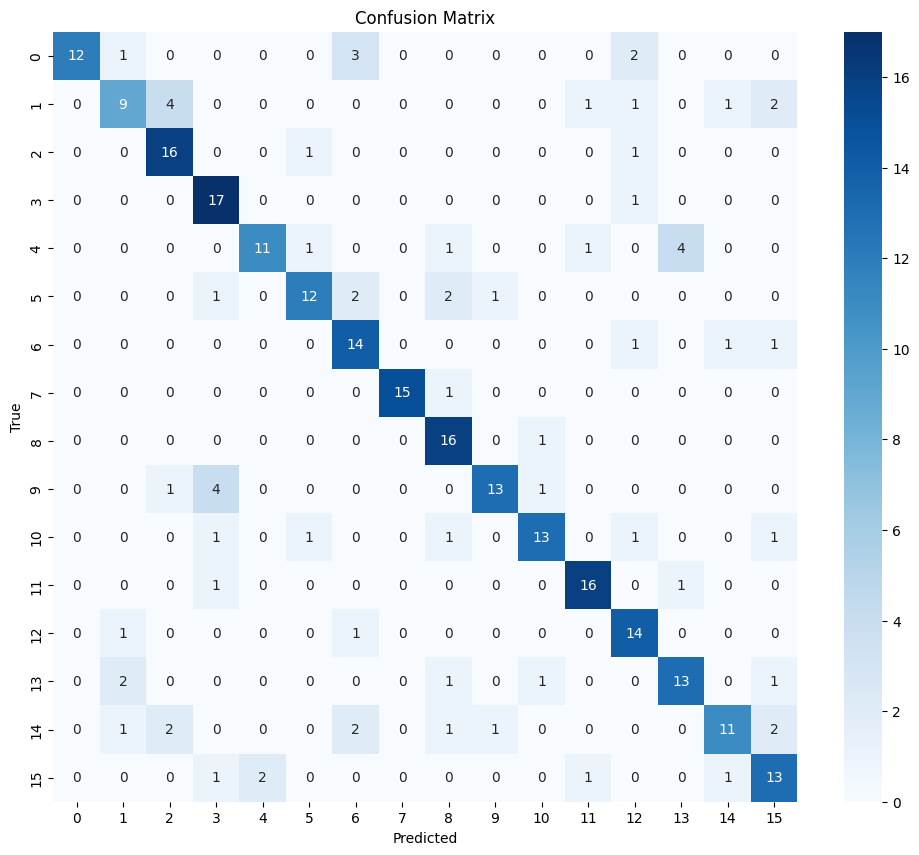


🔍 Classification Report:
              precision    recall  f1-score   support

        اختر       1.00      0.67      0.80        18
        اسفل       0.64      0.50      0.56        18
        اعلى       0.70      0.89      0.78        18
       انذار       0.68      0.94      0.79        18
 ايقاف تشغيل       0.85      0.61      0.71        18
       تشغيل       0.80      0.67      0.73        18
         جوع       0.64      0.82      0.72        17
         حذف       1.00      0.94      0.97        16
        حمام       0.70      0.94      0.80        17
        دواء       0.87      0.68      0.76        19
         عطش       0.81      0.72      0.76        18
          لا       0.84      0.89      0.86        18
       مسافة       0.67      0.88      0.76        16
         نعم       0.72      0.72      0.72        18
        يسار       0.79      0.55      0.65        20
        يمين       0.65      0.72      0.68        18

    accuracy                           0.75       285


In [ ]:
# EEGNet

# -------------------- 1. Imports --------------------
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D,
    SeparableConv2D, BatchNormalization, Activation, AveragePooling2D,
    Dropout, Flatten, Dense)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import pickle
import collections

# -------------------- 2. Advanced Data Augmentation --------------------
def add_noise(signal, noise_level=0.05):
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise

def time_shift(signal, shift_max=50):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(signal, shift, axis=0)

def scale_amplitude(signal, scale_range=(0.8, 1.2)):
    scale = np.random.uniform(scale_range[0], scale_range[1])
    return signal * scale

def mask_signal(signal, mask_ratio=0.1):
    mask_len = int(mask_ratio * signal.shape[0])
    start = np.random.randint(0, signal.shape[0] - mask_len)
    signal[start:start+mask_len] = 0
    return signal

def augment_segment(segment):
    if random.random() < 0.7:
        segment = add_noise(segment, noise_level=random.uniform(0.01, 0.1))
    if random.random() < 0.7:
        segment = time_shift(segment, shift_max=random.randint(10, 50))
    if random.random() < 0.7:
        segment = scale_amplitude(segment, scale_range=(0.7, 1.3))
    if random.random() < 0.3:
        segment = mask_signal(segment, mask_ratio=random.uniform(0.05, 0.15))
    return segment

# -------------------- 3. Prepare Dataset --------------------
X, y = [], []
for segment_array, label, participant in segmented_dataset:
    X.append(segment_array)
    y.append(label)

X = np.array(X)
y = np.array(y)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded)

X = np.expand_dims(X, axis=-1)
X = np.transpose(X, (0, 2, 1, 3))

with open("label_encoder_final.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# -------------------- 4. Augment Dataset --------------------
X_augmented, y_augmented = [], []
class_counts = collections.Counter(np.argmax(y_one_hot, axis=1))
max_count = max(class_counts.values())
class_multipliers = {cls: max(1, int(3.0 * max_count / count)) for cls, count in class_counts.items()}

for i in range(len(X)):
    X_augmented.append(X[i])
    y_augmented.append(y_one_hot[i])
    cls = np.argmax(y_one_hot[i])
    num_augmentations = min(class_multipliers[cls], 5)
    for _ in range(num_augmentations):
        augmented = augment_segment(X[i][:,:,0].T)
        augmented = np.expand_dims(augmented, axis=-1).transpose(1, 0, 2)
        X_augmented.append(augmented)
        y_augmented.append(y_one_hot[i])

X = np.array(X_augmented)
y = np.array(y_augmented)

# -------------------- 5. Train-Test Split --------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1)
)

# -------------------- 6. Mixup Function --------------------
def mixup_data(x, y, alpha=0.2):
    batch_size = x.shape[0]
    lam = np.random.beta(alpha, alpha)
    index = np.random.permutation(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index]
    mixed_y = lam * y + (1 - lam) * y[index]
    return mixed_x, mixed_y

# Apply mixup
X_train, y_train = mixup_data(X_train, y_train, alpha=0.2)

# -------------------- 7. Optimized EEGNet Model --------------------
def Optimized_EEGNet(nb_classes, Chans=11, Samples=1200, dropoutRate=0.4, kernLength=64, F1=24, D=2, F2=48, norm_rate=0.25):
    reg = tf.keras.regularizers.l2(1e-3)
    input1 = Input(shape=(Chans, Samples, 1))

    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False, kernel_regularizer=reg)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D,
                             depthwise_constraint=tf.keras.constraints.max_norm(1.),
                             depthwise_regularizer=reg)(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropoutRate)(block1)

    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same',
                             depthwise_regularizer=reg, pointwise_regularizer=reg)(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 4))(block2)
    block2 = Dropout(dropoutRate)(block2)

    block3 = SeparableConv2D(64, (1, 8), use_bias=False, padding='same',
                             depthwise_regularizer=reg, pointwise_regularizer=reg)(block2)
    block3 = BatchNormalization()(block3)
    block3 = Activation('elu')(block3)
    block3 = AveragePooling2D((1, 2))(block3)
    block3 = Dropout(dropoutRate)(block3)

    flatten = Flatten()(block3)
    dense1 = Dense(128, activation='elu', kernel_regularizer=reg,
                  kernel_constraint=tf.keras.constraints.max_norm(norm_rate))(flatten)
    dense1 = Dropout(dropoutRate)(dense1)
    dense2 = Dense(64, activation='elu', kernel_regularizer=reg,
                  kernel_constraint=tf.keras.constraints.max_norm(norm_rate))(dense1)
    dense2 = Dropout(dropoutRate)(dense2)
    dense = Dense(nb_classes, activation='softmax', kernel_constraint=tf.keras.constraints.max_norm(norm_rate))(dense2)

    return Model(inputs=input1, outputs=dense)

# -------------------- 8. Training Setup --------------------
model = Optimized_EEGNet(
    nb_classes=y_train.shape[1],
    Chans=X_train.shape[1],
    Samples=X_train.shape[2]
)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

# Learning rate scheduler
callbacks = [
    ModelCheckpoint('best_eegnet_model.keras', monitor='val_accuracy', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=15, min_lr=1e-6, verbose=1)
]

# -------------------- 9. Class Weights --------------------
class_weights = dict(
    enumerate(compute_class_weight(
        class_weight='balanced',
        classes=np.unique(np.argmax(y_train, axis=1)),
        y=np.argmax(y_train, axis=1)
    ))
)
class_weights = {cls: min(weight, 10.0) for cls, weight in class_weights.items()}

# -------------------- 10. Train Model --------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=400,
    batch_size=16,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# -------------------- 11. Test-Time Augmentation --------------------
def test_time_augmentation(model, X_test, n_augmentations=20):
    num_classes = model.output_shape[-1]
    all_predictions = np.zeros((X_test.shape[0], num_classes))
    all_predictions += model.predict(X_test)

    for _ in range(n_augmentations):
        X_test_aug = []
        for x in X_test:
            signal = x[:, :, 0]
            augmented = augment_segment(signal)
            augmented = np.expand_dims(augmented, axis=-1)
            X_test_aug.append(augmented)
        X_test_aug = np.array(X_test_aug)
        all_predictions += model.predict(X_test_aug)

    return all_predictions / (n_augmentations + 1)

# -------------------- 12. Final Evaluation --------------------
best_model = tf.keras.models.load_model('best_eegnet_model.keras')
y_pred_probs = test_time_augmentation(best_model, X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=-1)
y_true_labels = np.argmax(y_test, axis=-1)

accuracy = np.mean(y_pred_labels == y_true_labels)
print(f"\n✅ Test Accuracy (with TTA): {accuracy:.4f}")

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\n🔍 Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_))